# Set up

In [1]:
from wsi import filter
from wsi import slide
from wsi import util
from functools import partial
import openslide
%matplotlib inline

In [2]:
# Replace with WSI file path!
FILE = 'data/U.svs'

In [3]:
slide.slide_info(FILE)


Opening Slide: data/U.svs
Level count: 3
Level dimensions: ((29880, 26128), (7470, 6532), (1867, 1633))
Level downsamples: (1.0, 4.0, 16.002142474558113)
Dimensions: (29880, 26128)
Objective power: 20
Associated images:
  thumbnail: <PIL.Image.Image image mode=RGBA size=878x768 at 0x105770040>
Format: aperio
Time elapsed: 0:00:00.043272


RGB                  | Time: 0:00:00.000184  Type: uint8   Shape: (262, 300, 3)


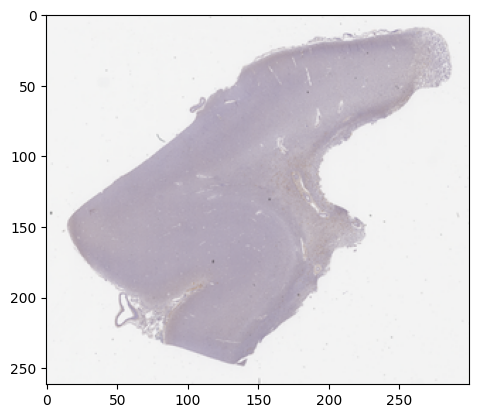

In [4]:
wsi = slide.open_slide(FILE)
img = util.pil_to_np_rgb(wsi.get_thumbnail((300, 500)))
util.display_img(img)

RGB                  | Time: 0:00:00.001015  Type: uint8   Shape: (816, 933, 3)


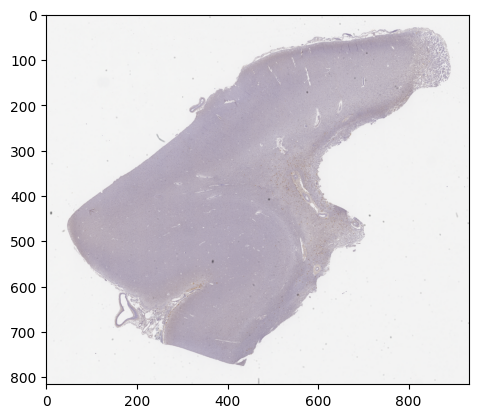

In [5]:
np_img = slide.slide_to_scaled_np_image(FILE, 32)
util.display_img(np_img)

# Complement + Otsu

Gray                 | Time: 0:00:00.021414  Type: uint8   Shape: (816, 933)
Complement           | Time: 0:00:00.000203  Type: uint8   Shape: (816, 933)


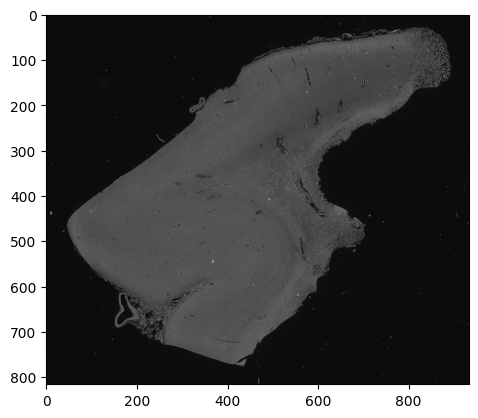

In [6]:
t = util.Time()
grayscale = filter.filter_rgb_to_grayscale(np_img)
complement = filter.filter_complement(grayscale)
util.display_img(complement)

Otsu Threshold       | Time: 0:00:00.017880  Type: uint8   Shape: (816, 933)


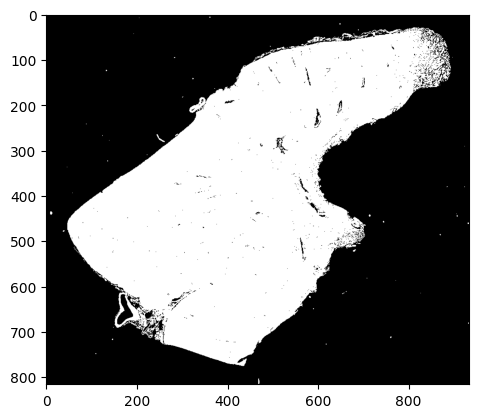

In [7]:
otsu = filter.filter_otsu_threshold(complement)
util.display_img(otsu)
otsu_time = t.elapsed()

Mask RGB             | Time: 0:00:00.003501  Type: uint8   Shape: (816, 933, 3)


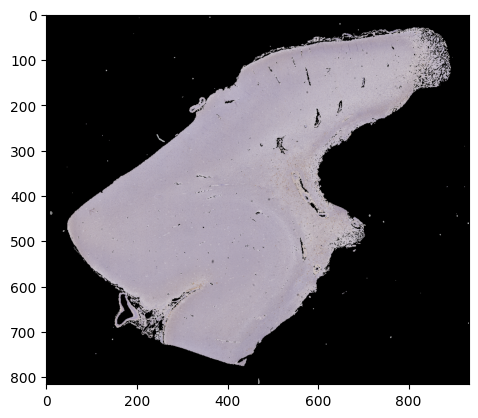

In [8]:
util.display_img(util.mask_rgb(np_img, otsu))

# Median + Saturation + Otsu + Dilation

Source: [A generalized deep learning framework for whole-slide image segmentation and analysis](https://www.nature.com/articles/s41598-021-90444-8)

Median filtering on RGB image

Median               | Time: 0:00:00.682063  Type: uint8   Shape: (816, 933, 3)


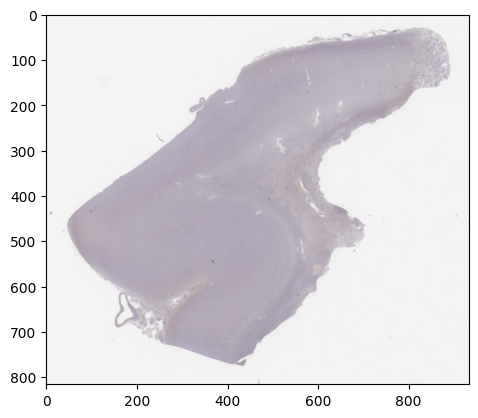

In [9]:
t = util.Time()
md = filter.filter_median(np_img, size=5)
util.display_img(md)

RGB to HSV           | Time: 0:00:00.152009  Type: float64 Shape: (816, 933, 3)


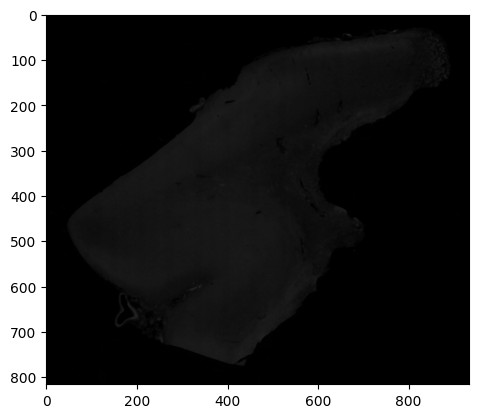

In [10]:
saturation = filter.filter_rgb_to_hsv(md)[:, :, 1]
util.display_img(saturation)

Otsu Threshold       | Time: 0:00:00.054574  Type: uint8   Shape: (816, 933)


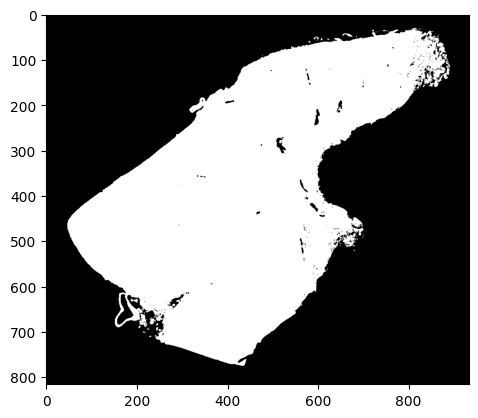

In [11]:
otsu = filter.filter_otsu_threshold(saturation)
util.display_img(otsu)

Binary Dilation      | Time: 0:00:00.048679  Type: uint8   Shape: (816, 933)


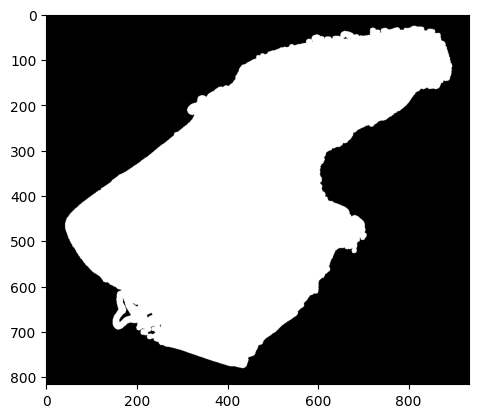

In [12]:
dilation = filter.filter_binary_dilation(otsu, disk_size=5)
util.display_img(dilation)
msod_time = t.elapsed()

Mask RGB             | Time: 0:00:00.003728  Type: uint8   Shape: (816, 933, 3)


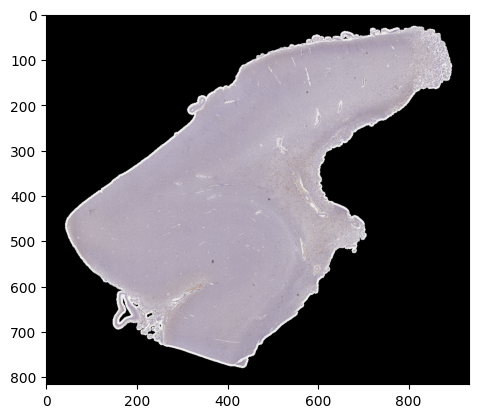

In [13]:
util.display_img(util.mask_rgb(np_img, dilation))

Pipelined filters:

Median               | Time: 0:00:02.456072  Type: uint8   Shape: (816, 933, 3)
RGB to HSV           | Time: 0:00:00.192247  Type: float64 Shape: (816, 933, 3)
Otsu Threshold       | Time: 0:00:00.017571  Type: uint8   Shape: (816, 933)
Binary Dilation      | Time: 0:00:00.052526  Type: uint8   Shape: (816, 933)
----------------------------------------------------------------------
Median + Saturation + Ostu + Dilation pipeline | Time: 0:00:02.719999  Type: uint8   Shape: (816, 933)


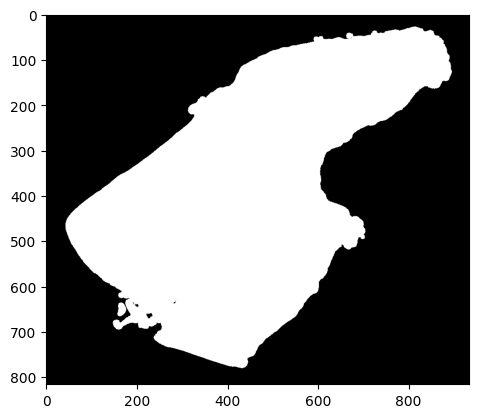

In [14]:
median = partial(filter.filter_median, size=10)
dilation = partial(filter.filter_binary_dilation, disk_size=5)
filtered = filter.filter_pipeline(
  np_img, 
  (
    median,
    filter.filter_rgb_to_hsv,
    (lambda hsv_img: hsv_img[:, : , 1]),
    filter.filter_otsu_threshold,
    dilation
  ),
  "Median + Saturation + Ostu + Dilation pipeline"
  )
util.display_img(filtered)

# Entropy Masker

Source: [An automatic entropy method to efficiently mask histology whole-slide images](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10017682/)

Gray                 | Time: 0:00:00.019930  Type: uint8   Shape: (816, 933)


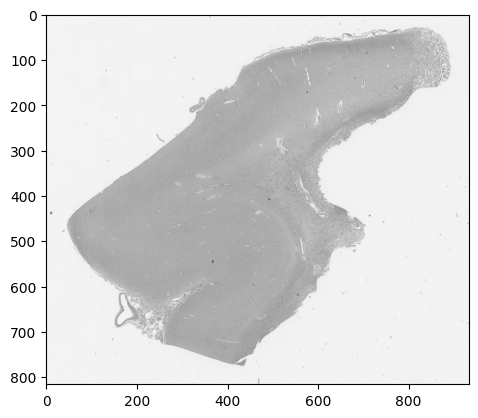

In [15]:
t = util.Time()
grayscale = filter.filter_rgb_to_grayscale(np_img)
util.display_img(grayscale)

Entropy              | Time: 0:00:00.702972  Type: uint8   Shape: (816, 933)


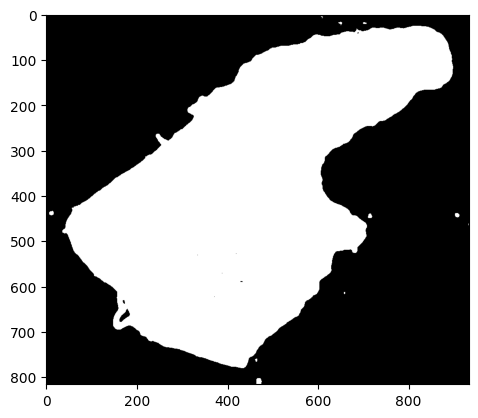

In [16]:
entropy = filter.filter_entropy(grayscale, neighborhood=12, threshold=3)
util.display_img(entropy)
entropy_time = t.elapsed()

Mask RGB             | Time: 0:00:00.003609  Type: uint8   Shape: (816, 933, 3)


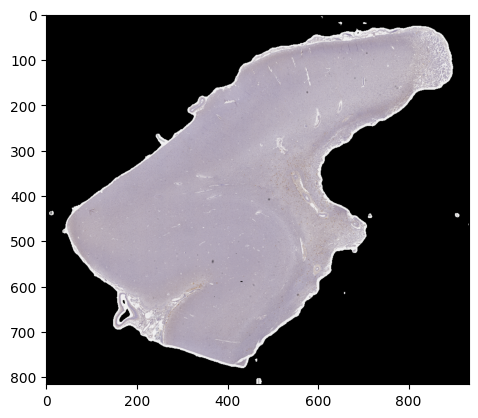

In [17]:
util.display_img(util.mask_rgb(np_img, entropy))

# Performance Comparison

In [18]:
import pandas as pd
data = [["Otsu", str(otsu_time)],
        ["Median + Saturation + Otsu + Dilation", str(msod_time)], 
        ["Entropy", str(entropy_time)]]
table = pd.DataFrame(data, columns=["Method", "Runtime"])
display(table)

,Method,Runtime
0,Otsu,0:00:00.285291
1,Median + Saturation + Otsu + Dilation,0:00:01.456968
2,Entropy,0:00:00.911101


# Filter Multiple WSI files

In [2]:
WSI_DIR = "data"
THUMBNAIL_DIR = "thumbnails"
SCALE = 64

In [3]:
slide.save_slide_dir_thumbnails(WSI_DIR, THUMBNAIL_DIR, SCALE)

TTT.svs
SS.svs
RR.svs
SSS.svs
RRR.svs
TT.svs
UUU.svs
UU.svs
S.svs
Q.svs
U.svs
T.svs
QQ.svs
QQQ.svs
